In [57]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Sequential

import numpy as np
import matplotlib.pyplot as plt

import os
import cv2
from keras.preprocessing.image import img_to_array
from tqdm import tqdm

np.random.seed(42)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
"""for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"for dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [58]:
with open('../input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Scene_Instances.txt') as f:
    instances = f.read()
    
instances = instances.split('\n')
instances[:5]

['0001_001_S6_00100_00060_3200_L',
 '0002_001_S6_00100_00020_3200_N',
 '0003_001_S6_00100_00060_3200_H',
 '0004_001_S6_00100_00060_4400_L',
 '0005_001_S6_00100_00060_4400_N']

In [59]:
path = '../input/smartphone-image-denoising-dataset/SIDD_Small_sRGB_Only/Data/'
noisy_images_path = []
gt_images_path = []

for f in instances:
    images_path = path + f + '/'
    
    for g in os.listdir(images_path):
        image_path = images_path + g
        
        if 'NOISY' in image_path:
            noisy_images_path.append(image_path)
        else:
            gt_images_path.append(image_path)

print('TOTAL NOISY IMAGES:', len(noisy_images_path))
print('TOTAL GROUND TRUTH IMAGES:', len(gt_images_path))

TOTAL NOISY IMAGES: 160
TOTAL GROUND TRUTH IMAGES: 160


In [60]:
IMG_SIZE = 1024
size = (IMG_SIZE, IMG_SIZE)

noisy_img_array = []

for f in tqdm(noisy_images_path):
    img = cv2.imread(f)
    img = cv2.resize(img, size)
    
    noisy_img_array.append(img)
    
gt_img_array = []

for f in tqdm(gt_images_path):
    img = cv2.imread(f)
    img = cv2.resize(img, size)
    
    gt_img_array.append(img)

100%|██████████| 160/160 [01:13<00:00,  2.16it/s]


In [61]:
noisy_img_array = np.array(noisy_img_array)
gt_img_array = np.array(gt_img_array)

print('NOISY IMG ARRAY:', noisy_img_array.shape)
print('GT IMG ARRAY:', gt_img_array.shape)

NOISY IMG ARRAY: (160, 1024, 1024, 3)
GT IMG ARRAY: (160, 1024, 1024, 3)


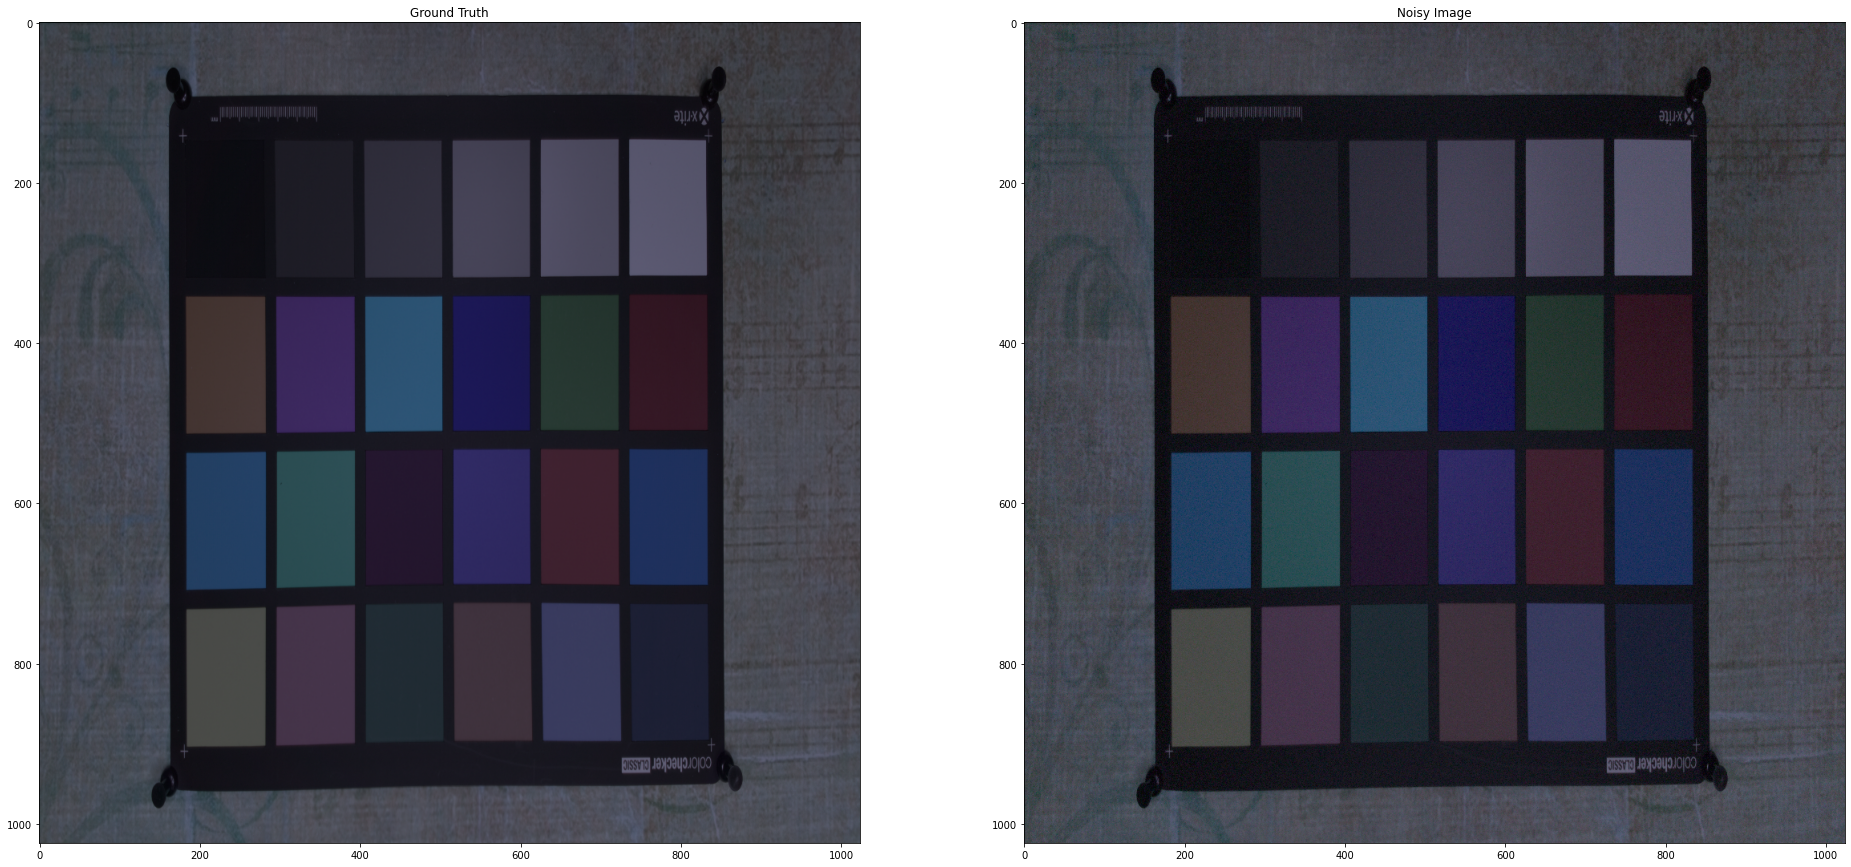

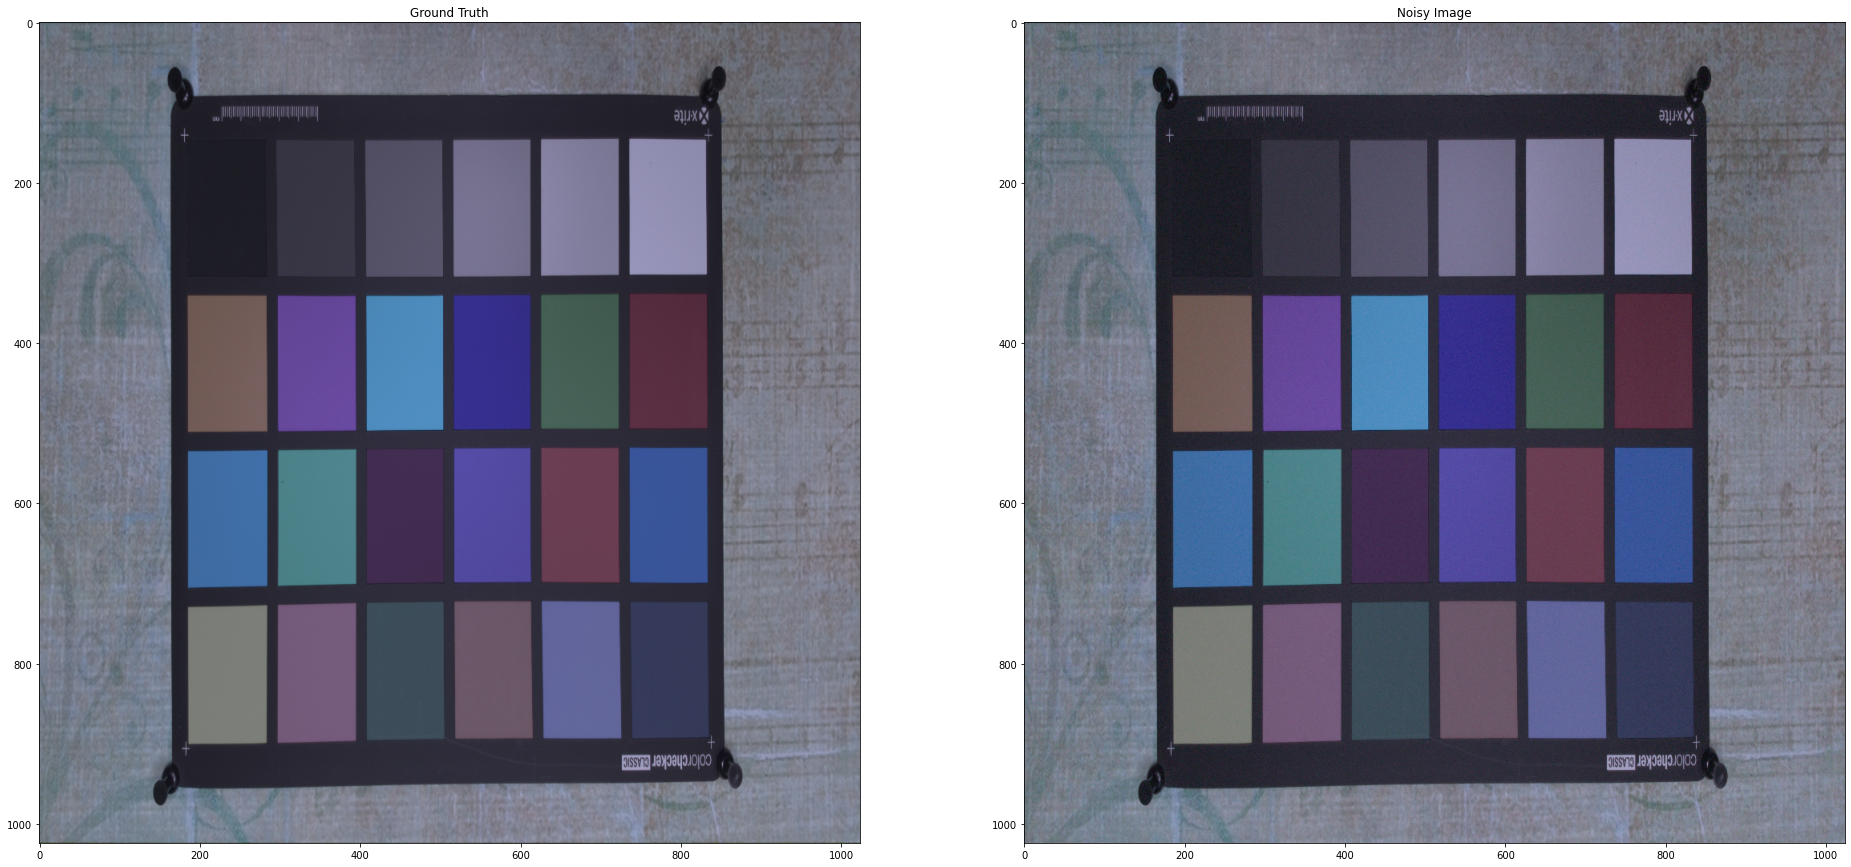

In [62]:
for i in range(2):
    # Since the images are of very high resolution,
    # it is difficult to notice a difference between them.
    # However if you observe closely, you will see a fuzziness in noisy images.
    
    fig=plt.figure(figsize=(50, 25))
    
    ax = plt.subplot(131)
    plt.title('Ground Truth')
    plt.imshow(gt_img_array[i])
    
    ax = plt.subplot(132)
    plt.title('Noisy Image')
    plt.imshow(noisy_img_array[i])
    plt.show()

In [63]:
noisy_train = np.reshape(noisy_img_array, (len(noisy_img_array), IMG_SIZE, IMG_SIZE, 3))
noisy_train = noisy_train.astype('float32') / 255.

clean_train = np.reshape(gt_img_array, (len(gt_img_array), IMG_SIZE, IMG_SIZE, 3))
clean_train = clean_train.astype('float32') / 255.


In [65]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
 

model.add(MaxPooling2D((2, 2), padding='same'))
     
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(8, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(3, (3, 3), activation='relu', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.summary()

2022-11-18 13:10:50.454032: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1024, 1024, 32)    896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 512, 512, 8)       2312      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 8)       584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 8)       5

In [66]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(noisy_train, clean_train, 
                                                    test_size = 0.20, random_state = 0)


In [67]:
model.fit(x_train, y_train, epochs=10, batch_size=8, shuffle=True, verbose = 1,
          validation_split = 0.1)


2022-11-18 13:11:45.873542: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10
15/15 [==============================] - 68s 4s/step - loss: 0.0445 - accuracy: 0.2482 - val_loss: 0.0100 - val_accuracy: 0.7419
Epoch 2/10
15/15 [==============================] - 68s 5s/step - loss: 0.0098 - accuracy: 0.7821 - val_loss: 0.0066 - val_accuracy: 0.7107
Epoch 3/10
15/15 [==============================] - 62s 4s/step - loss: 0.0067 - accuracy: 0.7832 - val_loss: 0.0052 - val_accuracy: 0.7411
Epoch 4/10
15/15 [==============================] - 61s 4s/step - loss: 0.0056 - accuracy: 0.7893 - val_loss: 0.0050 - val_accuracy: 0.7418
Epoch 5/10
15/15 [==============================] - 62s 4s/step - loss: 0.0053 - accuracy: 0.7910 - val_loss: 0.0048 - val_accuracy: 0.7423
Epoch 6/10
15/15 [==============================] - 61s 4s/step - loss: 0.0051 - accuracy: 0.7906 - val_loss: 0.0045 - val_accuracy: 0.7424
Epoch 7/10
15/15 [==============================] - 61s 4s/step - loss: 0.0049 - accuracy: 0.7896 - val_loss: 0.0044 - val_accuracy: 0.7359
Epoch 8/10
15/15 [==

In [68]:
model.save('denoising_autoencoder_custom_image.model')

2022-11-18 13:27:56.236717: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [69]:
no_noise_img = model.predict(x_test)

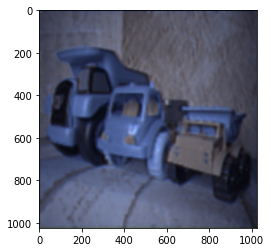

In [76]:
plt.imshow(no_noise_img[5])

In [2]:
from tensorflow import keras
model = keras.models.load_model('./denoising_autoencoder_custom_image.model')

In [30]:
from tensorflow.keras.utils import load_img
img_width, img_height = 1024, 1024
img = load_img('monalisaNoisy.png', target_size=(img_width, img_height))

In [21]:
from tensorflow.keras.utils import img_to_array
import numpy as np
test_img = img_to_array(img)
test_img  = np.expand_dims(test_img, axis=0)

test_img.shape

(1, 1024, 1024, 3)

In [22]:
test_img_pred = model.predict(test_img)

2022-11-18 16:56:24.523438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 682ms/step


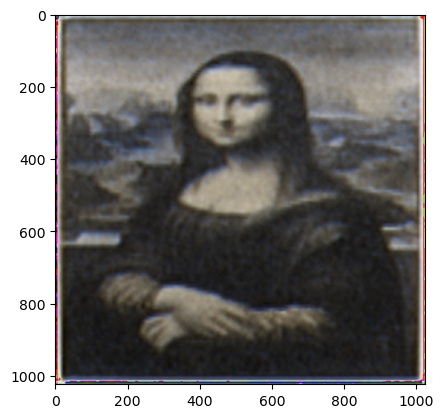

In [28]:
import matplotlib.pyplot as plt
test_img_pred = np.squeeze(test_img_pred)
plt.imshow((test_img_pred).astype(np.uint8))